In [1]:
using Markdown#hide

# Monte Carlo (Concrete) Dropout: Bayesian Neural Network (BNN) for a regression task

From [https://github.com/aurelio-amerio/ConcreteDropout/blob/main/examples/Tensorflow/regression_MCDropout.ipynb](https://github.com/aurelio-amerio/ConcreteDropout/blob/main/examples/Tensorflow/regression_MCDropout.ipynb).
For more information on this BNN implementation, see https://arxiv.org/pdf/1703.04977.pdf

In [2]:
using Lux
using Optimisers, Zygote
using Random
using MLUtils: DataLoader
using StatsBase
using StatsPlots
using ConcreteDropoutLayer

Random.seed!(MersenneTwister(1))

MersenneTwister(0x1825826fbf8f419a21451a3af6ee7700)

## Data

In [3]:
function gen_data(N; in=1, out=1)
    X = randn(Float32, Q, N)
    σ = 1
    w = 2
    b = 8
    Y = w * ones(out, in) * X .+ b + σ * randn(Float32, out, N)
    return X, Y
end

gen_data (generic function with 1 method)

## Neural network functions

In [4]:
function build_model_dropout(in, out)
    Chain(
        Dense(in => 100, relu),
        Dense(100 => 100, relu),
        ConcreteDropout(),
        Dense(100 => 100, relu),
        ConcreteDropout(),
        Parallel(nothing,
            Chain(Dense(100 => out, relu), ConcreteDropout()),
            Chain(Dense(100 => out, relu), ConcreteDropout())
        )
    )
end

function build_model_dropout(in, out, p)
    Chain(
        Dense(in => 100, relu),
        Dense(100 => 100, relu),
        Dropout(p),
        Dense(100 => 100, relu),
        Dropout(p),
        Parallel(nothing,
            Chain(Dense(100 => out, relu), Dropout(p)),
            Chain(Dense(100 => out, relu), Dropout(p))
        )
    )
end

build_model_dropout (generic function with 2 methods)

## Loss functions

In [5]:
function heteroscedastic_loss(y_pred, y_true)
    μ, log_var = y_pred
    precision = exp.(-log_var)
    return sum(precision .* (y_true - μ) .^ 2 + log_var)
end

function compute_loss_heteroscedastic(model, ps, st, (x, y))
    ŷ, st = model(x, ps, st)
    return heteroscedastic_loss(ŷ, y), st, ()
end

compute_loss_heteroscedastic (generic function with 1 method)

Version with the added regularization suggested in the original paper. `(names_CD, names_W, input_features), λp, λW` are provided and constant during the training.

In [6]:
function compute_loss_heteroscedastic_w_reg(model, ps, st, (x, y), (names_CD, names_W, input_features), λp, λW)
    ŷ, st = model(x, ps, st)
    drop_rates, W = get_regularization(ps, names_CD, names_W)

    return heteroscedastic_loss(ŷ, y) + computeCD_reg(drop_rates, W, input_features, λp, λW), st, ()
end

compute_loss_heteroscedastic_w_reg (generic function with 1 method)

## Training functions

In [7]:
function train_step(train_state, xy, compute_loss)
    # Calculate the gradient of the objective
    # with respect to the parameters within the model:
    x, y = xy

    gs, loss, _, train_state = Lux.Experimental.compute_gradients(
                AutoZygote(), compute_loss, (x, y), train_state
    )
    train_state = Lux.Experimental.apply_gradients(train_state, gs)

    return loss, train_state
end


"""
	train(model, epochs, dataset, dataset_val, compute_loss; learning_rate=0.001f0, dev = cpu_device())
Train the `model` and comute at each epoch the training and testing loss
"""
function train(model, epochs, dataset, dataset_val, compute_loss; learning_rate=0.001f0, dev = cpu_device())
    # Set up models
    rng = Xoshiro(0)

    train_state = Lux.Experimental.TrainState(rng, model, Adam(learning_rate); transform_variables=dev)

    ps = train_state.parameters
    st = train_state.states
    model = train_state.model

    # Validation Loss
    losses_train = Float32[]
    x_val, y_val = dataset_val |> dev
    losses_val = Float32[first(compute_loss(model, ps, st, (x_val, y_val)))]
    loss = rand(Float32) # just to define loss in outer loop scope # probably better ways to do that
    best_test_state = train_state

    # Training loop
    for epoch in 1:epochs
        issave = false
        for xy in dataset
            xy = xy |> dev
            loss, train_state = train_step(train_state, xy, compute_loss)
        end
        ps = train_state.parameters
        st = train_state.states
        loss_val = first(compute_loss(model, ps, st, (x_val, y_val)))
        if loss_val < minimum(losses_val)
            best_test_state = train_state
            issave = true
        end
        append!(losses_train, loss)
        append!(losses_val, loss_val)
        @info "Epoch $epoch train_loss = $(round(loss, digits = 4)) validation_loss = $(round(loss_val, digits = 4)) $(issave ? "Best model so far" : " ")"
    end
    return best_test_state, losses_train, losses_val
end

Main.var"##1869".train

# Data & Settings

In [8]:
Q = 1
D = 1
n_train = 1000
n_test = 500

using LuxCUDA
dev = gpu_device()

x_train, y_train = gen_data(n_train, in=Q, out=D)

x_test, y_test = gen_data(n_test, in=Q, out=D)

batch_size = 128
epochs = 100
data_train = DataLoader((x_train, y_train), batchsize=batch_size) |> dev
data_test = (x_test, y_test) |> dev

(Float32[1.354469 0.18101627 … 1.2697732 -0.88543224], Float32[11.548834 8.90199 … 9.912215 4.9701724])

# Training

## Dropout Model

In [9]:
fix_dropout = 0.1
model_CNN_D = build_model_dropout(Q, D, fix_dropout)

Chain(
    layer_1 = Dense(1 => 100, relu),    # 200 parameters
    layer_2 = Dense(100 => 100, relu),  # 10_100 parameters
    layer_3 = Dropout(0.1),
    layer_4 = Dense(100 => 100, relu),  # 10_100 parameters
    layer_5 = Dropout(0.1),
    layer_6 = Parallel(
        layer_1 = Chain(
            layer_1 = Dense(100 => 1, relu),  # 101 parameters
            layer_2 = Dropout(0.1),
        ),
        layer_2 = Chain(
            layer_1 = Dense(100 => 1, relu),  # 101 parameters
            layer_2 = Dropout(0.1),
        ),
    ),
)         # Total: 20_602 parameters,
          #        plus 8 states.

In [10]:
@time "Dropout model" model_state_out_D, loss_train_D, loss_val_D = train(model_CNN_D, epochs, data_train, data_test, compute_loss_heteroscedastic; dev = gpu_device())

[ Info: Epoch 1 train_loss = 6269.6665 validation_loss = 28680.205 Best model so far
[ Info: Epoch 2 train_loss = 4196.6504 validation_loss = 19205.395 Best model so far
[ Info: Epoch 3 train_loss = 2356.2808 validation_loss = 10664.658 Best model so far
[ Info: Epoch 4 train_loss = 1461.8887 validation_loss = 6661.1377 Best model so far
[ Info: Epoch 5 train_loss = 1088.513 validation_loss = 5445.629 Best model so far
[ Info: Epoch 6 train_loss = 1046.734 validation_loss = 4758.918 Best model so far
[ Info: Epoch 7 train_loss = 885.7898 validation_loss = 4150.1304 Best model so far
[ Info: Epoch 8 train_loss = 855.0356 validation_loss = 3857.2107 Best model so far
[ Info: Epoch 9 train_loss = 667.144 validation_loss = 3782.265 Best model so far
[ Info: Epoch 10 train_loss = 871.7429 validation_loss = 3513.9685 Best model so far
[ Info: Epoch 11 train_loss = 580.6906 validation_loss = 3625.3157  
[ Info: Epoch 12 train_loss = 534.3548 validation_loss = 2815.0928 Best model so far
[ Inf

(Lux.Experimental.TrainState{Nothing, Nothing, Chain{@NamedTuple{layer_1::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_2::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_3::Dropout{Float64, Colon}, layer_4::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_5::Dropout{Float64, Colon}, layer_6::Parallel{Nothing, @NamedTuple{layer_1::Chain{@NamedTuple{layer_1::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_2::Dropout{Float64, Colon}}, Nothing}, layer_2::Chain{@NamedTuple{layer_1::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_2::Dropout{Float64, Colon}}, Nothing}}, Nothing}}, Nothing}, @NamedTuple{layer_1::@NamedTuple{weight::CuArray{Float32, 2, CUDA.DeviceMemory}, bias::CuArray{Float32, 2, CUDA.DeviceMemory}}, layer_2::@NamedTuple{weight::CuArray{Float32, 2, CUDA.DeviceMemory}, bias::CuArray{Float32, 2, CUDA.DeviceMemory}}, layer_3::@NamedTuple{}, layer_4::

## Concrete Dropout Model

### Without regularization

In [11]:
model_CNN_CD = build_model_dropout(Q, D)

Chain(
    layer_1 = Dense(1 => 100, relu),    # 200 parameters
    layer_2 = Dense(100 => 100, relu),  # 10_100 parameters
    layer_3 = ConcreteDropout(),        # 1 parameters, plus 2
    layer_4 = Dense(100 => 100, relu),  # 10_100 parameters
    layer_5 = ConcreteDropout(),        # 1 parameters, plus 2
    layer_6 = Parallel(
        layer_1 = Chain(
            layer_1 = Dense(100 => 1, relu),  # 101 parameters
            layer_2 = ConcreteDropout(),  # 1 parameters, plus 2
        ),
        layer_2 = Chain(
            layer_1 = Dense(100 => 1, relu),  # 101 parameters
            layer_2 = ConcreteDropout(),  # 1 parameters, plus 2
        ),
    ),
)         # Total: 20_606 parameters,
          #        plus 8 states.

In [12]:
@time "Concrete Dropout model" model_state_out_CD, loss_train_CD, loss_val_CD = train(model_CNN_CD, epochs, data_train, data_test, compute_loss_heteroscedastic; dev = gpu_device())

[ Info: Epoch 1 train_loss = 5089.705 validation_loss = 23575.932 Best model so far
[ Info: Epoch 2 train_loss = 3744.5613 validation_loss = 15090.98 Best model so far
[ Info: Epoch 3 train_loss = 1762.1666 validation_loss = 9186.246 Best model so far
[ Info: Epoch 4 train_loss = 1115.263 validation_loss = 5685.2524 Best model so far
[ Info: Epoch 5 train_loss = 1230.8403 validation_loss = 6053.6406  
[ Info: Epoch 6 train_loss = 968.0298 validation_loss = 4781.3516 Best model so far
[ Info: Epoch 7 train_loss = 1187.6045 validation_loss = 4843.877  
[ Info: Epoch 8 train_loss = 711.7212 validation_loss = 4187.9097 Best model so far
[ Info: Epoch 9 train_loss = 941.0627 validation_loss = 4074.8933 Best model so far
[ Info: Epoch 10 train_loss = 696.8652 validation_loss = 3799.834 Best model so far
[ Info: Epoch 11 train_loss = 615.4882 validation_loss = 3366.636 Best model so far
[ Info: Epoch 12 train_loss = 532.9914 validation_loss = 3036.982 Best model so far
[ Info: Epoch 13 train_

(Lux.Experimental.TrainState{Nothing, Nothing, Chain{@NamedTuple{layer_1::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_2::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_3::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}, layer_4::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_5::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}, layer_6::Parallel{Nothing, @NamedTuple{layer_1::Chain{@NamedTuple{layer_1::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_2::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}}, Nothing}, layer_2::Chain{@NamedTuple{layer_1::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_2::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}}, Nothing}}, Nothing}}, Nothing}, @NamedTuple{layer_1::@NamedTuple{weight::CuArray{Float32, 2, CUDA.DeviceMemory}, bias::CuArray{Float32, 2, CUDA.DeviceMemory}}, layer_2::@NamedTu

### With regularization

In [13]:
wr = get_weight_regularizer(n_train, l=1.0f-2, τ=1.0f0)
dr = get_dropout_regularizer(n_train, τ=1.0f0, cross_entropy_loss=false)

0.002f0

In [14]:
p_cd, w_cd, KK = regularization_infos(Lux.Experimental.TrainState(Xoshiro(0), model_CNN_CD, Adam(0.1f0); transform_variables=dev))
@time "Concrete Dropout model reg" model_state_out_CD_reg, loss_train_CD_reg, loss_val_CD_reg = train(model_CNN_CD, epochs, data_train, data_test, (model, ps, st, xy) -> compute_loss_heteroscedastic_w_reg(model, ps, st, xy, (p_cd, w_cd, KK), dr, wr); dev = gpu_device())

[ Info: Epoch 1 train_loss = 5089.1523 validation_loss = 23573.828 Best model so far
[ Info: Epoch 2 train_loss = 3743.7925 validation_loss = 15087.747 Best model so far
[ Info: Epoch 3 train_loss = 1761.2758 validation_loss = 9182.826 Best model so far
[ Info: Epoch 4 train_loss = 1113.5056 validation_loss = 5679.8174 Best model so far
[ Info: Epoch 5 train_loss = 1229.9988 validation_loss = 6051.621  
[ Info: Epoch 6 train_loss = 968.438 validation_loss = 4783.9917 Best model so far
[ Info: Epoch 7 train_loss = 1188.3053 validation_loss = 4848.7017  
[ Info: Epoch 8 train_loss = 714.0696 validation_loss = 4200.2646 Best model so far
[ Info: Epoch 9 train_loss = 944.0378 validation_loss = 4094.2493 Best model so far
[ Info: Epoch 10 train_loss = 698.5442 validation_loss = 3818.2373 Best model so far
[ Info: Epoch 11 train_loss = 617.476 validation_loss = 3371.327 Best model so far
[ Info: Epoch 12 train_loss = 530.8039 validation_loss = 3018.2507 Best model so far
[ Info: Epoch 13 tra

(Lux.Experimental.TrainState{Nothing, Nothing, Chain{@NamedTuple{layer_1::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_2::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_3::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}, layer_4::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_5::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}, layer_6::Parallel{Nothing, @NamedTuple{layer_1::Chain{@NamedTuple{layer_1::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_2::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}}, Nothing}, layer_2::Chain{@NamedTuple{layer_1::Dense{true, typeof(relu), typeof(glorot_uniform), typeof(zeros32)}, layer_2::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}}, Nothing}}, Nothing}}, Nothing}, @NamedTuple{layer_1::@NamedTuple{weight::CuArray{Float32, 2, CUDA.DeviceMemory}, bias::CuArray{Float32, 2, CUDA.DeviceMemory}}, layer_2::@NamedTu

# Result

## Training loss

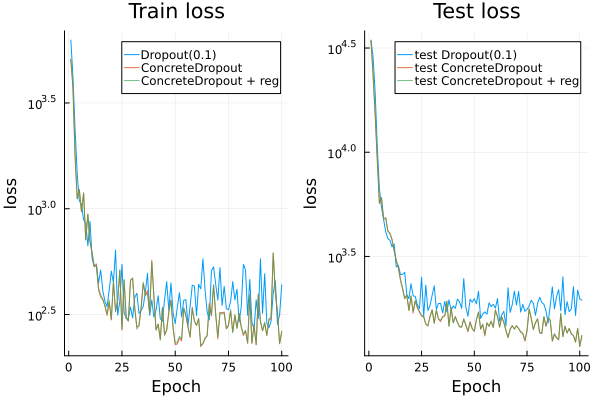

In [15]:
begin
    p_train = plot(loss_train_D, label="Dropout($fix_dropout)", title="Train loss")
    plot!(loss_train_CD, label="ConcreteDropout")
    plot!(loss_train_CD_reg, label="ConcreteDropout + reg", alpha = 0.7)
    xlabel!("Epoch")
    ylabel!("loss", yscale = :log10)
    p_test = plot(loss_val_D, label="test Dropout($fix_dropout)", title="Test loss")
    plot!(loss_val_CD, label="test ConcreteDropout")
    plot!(loss_val_CD_reg, label="test ConcreteDropout + reg", alpha = 0.7)
    xlabel!("Epoch")
    ylabel!("loss", yscale = :log10)
    plot(p_train, p_test)
end

## Monte Carlo predictions

In [16]:
"""
	MC_predict(model, X::AbstractArray{T}; n_samples=1000, kwargs...)
For each X it returns `n_samples` monte carlo simulations where the randomness comes from the (Concrete)Dropout layers.
"""
function MC_predict(model_state, X::AbstractArray, n_samples=1000; dev = gpu_device(), dim_out = model_state.model[end].layers[1].out_dims)
    st = model_state.states
    ps = model_state.parameters
    model = model_state.model

    dim_N = ndims(X)
    mean_arr = similar(X, dim_out, size(X, dim_N))
    std_dev_arr = similar(X, dim_out, size(X, dim_N))

    X = X |> dev
    X_in = similar(X, size(X)[1:end-1]..., n_samples) |> dev


    for (i, x) in enumerate(eachslice(X, dims=dim_N, drop = false))
        X_in .= x
        predictions, st = model(X_in, ps, st)
        θs_MC, logvars = predictions |> cpu_device()

        θ_hat = mean(θs_MC, dims=2) # predictive_mean

        θ2_hat = mean(θs_MC .^ 2, dims=2) # θ2_hat = mean(θs_MC' * θs_MC, dims=2)
        var_mean = mean(exp.(logvars), dims=2) # aleatoric_uncertainty
        total_var = θ2_hat - θ_hat .^ 2 + var_mean
        std_dev = sqrt.(total_var)

        mean_arr[:, i] .= θ_hat
        std_dev_arr[:, i] .= std_dev
    end

    return mean_arr, std_dev_arr
end

y_pred, y_std = MC_predict(model_state_out_CD_reg, x_test, dev = dev, dim_out = D)
y_pred_d, y_std_d = MC_predict(model_state_out_D, x_test, dev = dev, dim_out = D)

(Float32[9.883528 7.593921 … 9.666417 5.392767], Float32[4.6814218 3.800577 … 4.685681 2.8670635])

Plot prediction plus standard deviation (aleatoric + epistemic)

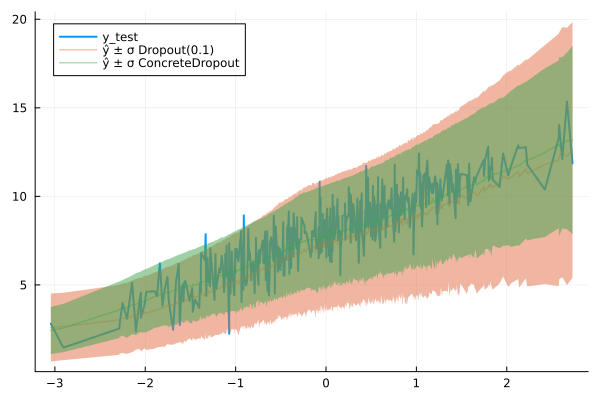

In [17]:
begin
    argsort = sortperm(x_test, dims=2)
    x_sorted = x_test[argsort]'
    y_true_sorted = y_test[argsort]'

    plot(x_sorted, y_true_sorted, label="y_test", lw = 2)
    plot!(x_sorted, y_pred_d[argsort]', ribbon=y_std_d[argsort]', label="ŷ ± σ Dropout(0.1)", alpha=0.4, lw = 1.5)
    plot!(x_sorted, y_pred[argsort]', ribbon=y_std[argsort]', label="ŷ ± σ ConcreteDropout", alpha=0.4, lw = 1.5)
end

Print all learned Dropout rates.

In [18]:
function print_p_CD(l, ps, st, name)
    if l isa ConcreteDropout
        println("p = $(sigmoid(ps.p_logit)) of $name")
    end
    return l, ps, st
end;
Lux.Experimental.@layer_map print_p_CD model_state_out_CD.model model_state_out_CD.parameters model_state_out_CD.parameters;

p = Float32[0.074241795] of model_state_out_CD.model.layers.layer_3
p = Float32[0.06898067] of model_state_out_CD.model.layers.layer_5
p = Float32[0.056299094] of model_state_out_CD.model.layers.layer_6.layers.layer_1.layers.layer_2
p = Float32[0.083094686] of model_state_out_CD.model.layers.layer_6.layers.layer_2.layers.layer_2


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*